# aSPEM Experiment : analysis




In [1]:
%load_ext autoreload
%autoreload 2
from __future__ import division, print_function, absolute_import
import glob
import pickle
import matplotlib.pyplot as plt
#from cycler import cycler
import numpy as np
import scipy as sc
from scipy import stats
#from scipy.stats import beta

In [2]:
%matplotlib inline
fig_width = 15

from aSPEM import aSPEM
import bayesianchangepoint as bcp

In [3]:
liste = []
for fname in glob.glob('data/*pkl'):
    a = fname.split('/')[1].split('.')[0].split('_')
    liste.append(a)
    #print(a)

In [4]:
exp = []
for x in range(len(liste)) :
    if liste[x][0]=='pari' and liste[x][1] in ['AM','BMC','CS','DC','FM','IP','LB','OP','RS','SR','TN','YK']:
        a = 'data/%s_%s_%s_%s.pkl'%(liste[x][0], liste[x][1],liste[x][2],liste[x][3])
        with open(a, 'rb') as fichier :
            b = pickle.load(fichier, encoding='latin1')
            exp.append(b)

In [5]:
param = []
for x in range(len(liste)) :
    if liste[x][0]=='pari' and liste[x][1] in ['AM','BMC','CS','DC','FM','IP','LB','OP','RS','SR','TN','YK']:
        a = 'parametre/param_Fit_%s_fct_velocity_2_step_False_whitening.pkl'%(liste[x][1])
        with open(a, 'rb') as fichier :
            b = pickle.load(fichier, encoding='latin1')
            param.append(b)

In [6]:
def regress(ax, p, data, c, minx=0, miny=0, maxx=1, maxy=1, t_label=14) :
    from scipy import stats
    slope, intercept, r_, p_value, std_err = stats.linregress(p, data)
    x_test = np.linspace(np.min(p), np.max(p), 100)
    fitLine = slope * x_test + intercept
    ax.plot(x_test, fitLine, c=c, linewidth=2)
    ax.text(maxx-((maxx-minx)/16.180), miny+((maxy-miny)/4), 'r = %0.3f'%(r_), fontsize=t_label/1.2, ha='right', color=c)
    ax.text(maxx-((maxx-minx)/16.180), miny+((maxy-miny)/10), 'p_value = %0.3f'%(p_value), fontsize=t_label/1.2, ha='right', color=c)

    return ax

In [7]:
def scatter_mean(bet, va, titre) :
    fig, axs = plt.subplots(1, 2, figsize=((fig_width), (fig_width)/(1.6180*2)))
    plt.suptitle(titre, fontsize=20, y=1.05)

    c = ['k', 'r']
    c1 = ['r', 'k']
    for s, mode in enumerate(['expectation', 'max']):
        m_bet, m_va = [], []
        for x in range(len(bet[mode])):
            axs[s].errorbar(np.mean(bet[mode][x]), np.mean(va[mode][x]),
                            xerr=np.std(bet[mode][x]), yerr=np.std(va[mode][x]),
                            color=c[s], fmt='o', elinewidth=0.8)
            m_bet.append(np.mean(bet[mode][x]))
            m_va.append(np.mean(va[mode][x]))

        axs[s].set_title('mode %s'%mode, fontsize=20)
        axs[s].set_xlabel('h$_{bet}$', fontsize=14)
        axs[s].set_ylabel('h$_{v_a}$', fontsize=14)
        axs[s].axis([-0.03 ,1.03,-0.03,1.03])

        regress(axs[s], m_bet, m_va, c1[s])

    plt.show()

In [8]:
def scatter_full(h_bet, h_va, titre):
    fig, axs = plt.subplots(1, 2, figsize=((fig_width), (fig_width)/(1.6180*2)))
    plt.suptitle(titre, fontsize=20, y=1.05)
    fig2, axs2 = plt.subplots(12, 2, figsize=((fig_width), 12*(fig_width)/(1.6180*2)))

    for s, mode in enumerate(['expectation', 'max']):
        bet_mode, va_mode = [], []
        bet_mode_0, va_mode_0 = [], []
        for x, color in enumerate(['black','dimgrey','grey','darkgrey','silver','rosybrown','lightcoral','indianred','firebrick','brown','darkred','red']):
            for a in range(len(h_bet[mode][x])):
                axs[s].scatter(h_bet[mode][x][a], h_va[mode][x][a],color=color, edgecolors='c')
                axs2[x][s].scatter(h_bet[mode][x][a], h_va[mode][x][a],color=color, edgecolors='c')
                if a != 0 :
                    axs[s].scatter(h_bet[mode][x][a], h_va[mode][x][a],color=color, edgecolors=color)
                    axs2[x][s].scatter(h_bet[mode][x][a], h_va[mode][x][a],color=color, edgecolors=color)

                    bet_mode_0.append(h_bet[mode][x][a])
                    va_mode_0.append(h_va[mode][x][a])
                bet_mode.append(h_bet[mode][x][a])
                va_mode.append(h_va[mode][x][a])

            regress(axs2[x][s], h_bet[mode][x], h_va[mode][x], 'r')
            regress(axs2[x][s], h_bet[mode][x][1:], h_va[mode][x][1:], 'k', miny=0.5)
            
            axs2[x][s].set_title('%s mode %s'%(x,mode), fontsize=20)
            axs2[x][s].set_xlabel('h$_{bet}$', fontsize=14)
            axs2[x][s].set_ylabel('h$_{v_a}$', fontsize=14)
            axs2[x][s].axis([-0.03 ,1.03,-0.03,1.03])

        #------------------------------------------------------------------------
        axs[s].set_title('mode %s'%mode, fontsize=20)
        axs[s].set_xlabel('h$_{bet}$', fontsize=14)
        axs[s].set_ylabel('h$_{v_a}$', fontsize=14)
        axs[s].axis([-0.03 ,1.03,-0.03,1.03])


        regress(axs[s], bet_mode_0, va_mode_0, 'r')
        regress(axs[s], bet_mode, va_mode, 'k', miny=0.5)

    fig2.tight_layout()
    plt.show()

# Variation de h

In [9]:
from lmfit import  Model, Parameters

In [10]:
def fct_BCP(x, h, num_mode) :
    if num_mode==0 :
        mode = 'expectation'
    elif num_mode==1:
        mode = 'max'
    p_bar, r, beliefs = bcp.inference(x, h=h, p0=.5)
    p_hat, r_hat = bcp.readout(p_bar, r, beliefs, mode=mode)
    
    return p_hat

In [11]:
def fit(h, proba, bet, va, num_mode):
    params = Parameters()
    model = Model(fct_BCP)

    params.add('h', value=h, min=0.00001, max=0.99999)
    params.add('num_mode', value=num_mode, vary=False)

    result_res = model.fit(bet, params, x=proba, nan_policy='omit')
    result_v_ant = model.fit(va, params, x=proba, nan_policy='omit')

    h_bet = result_res.values['h']
    h_va = result_v_ant.values['h']
    
    return h_bet, h_va

In [12]:
h_bet_pause, h_va_pause = {'expectation':[], 'max':[]}, {'expectation':[], 'max':[]}
h_bet_block, h_va_block = {'expectation':[], 'max':[]}, {'expectation':[], 'max':[]}
h_bet_sujet, h_va_sujet = {'expectation':[], 'max':[]}, {'expectation':[], 'max':[]}

for x in range(len(exp)) :
    
    prob_sujet, bet_sujet, v_anti_sujet = [], [], []

    p = exp[x]['p']
    tau = exp[x]['N_trials']/5.
    h = 1./tau 
    #hs = h*np.logspace(-1., 1., 50)
    #print(hs)
    bet = (exp[x]['results']+1)/2 # results est sur [-1,1] on le ramene sur [0,1]
    v_anti = param[x]['v_anti']

    for s, mode in enumerate(['expectation', 'max']):
        h_bet_block[mode].append([])
        h_bet_pause[mode].append([])
        h_va_block[mode].append([])
        h_va_pause[mode].append([])
        
        if mode=='expectation':
            num_mode=0
        elif mode=='max':
            num_mode=1
        
        for block in range(exp[x]['N_blocks']):

            prob_block = p[:, block, 0]
            h_bet, h_va = fit(h, prob_block, bet[:, block], v_anti[block], num_mode)
            
            h_bet_block[mode][x].append(h_bet)
            h_va_block[mode][x].append(h_va)

            prob_sujet.extend(p[:, block, 0])
            bet_sujet.extend(bet[:, block])
            v_anti_sujet.extend(v_anti[block])
            #----------------------------------------------------
            # Pour chaque pause !
            #----------------------------------------------------
            liste = [0,50,100,150,200]
            for a in range(len(liste)-1) :
                prob_pause = p[liste[a]:liste[a+1], block, 0]
                h_bet, h_va = fit(h, prob_pause, bet[liste[a]:liste[a+1], block], v_anti[block][liste[a]:liste[a+1]], num_mode)
                
                h_bet_pause[mode][x].append(h_bet)
                h_va_pause[mode][x].append(h_va)
                

        h_bet, h_va = fit(h, prob_sujet, bet_sujet, v_anti_sujet, num_mode)
        h_bet_sujet[mode].append(h_bet)
        h_va_sujet[mode].append(h_va)

/usr/local/lib/python3.5/dist-packages/scipy/stats/_stats_mstats_common.py:107: RuntimeWarning: invalid value encountered in double_scalars
  slope = r_num / ssxm
/usr/local/lib/python3.5/dist-packages/scipy/stats/_stats_mstats_common.py:119: RuntimeWarning: invalid value encountered in double_scalars
  sterrest = np.sqrt((1 - r**2) * ssym / ssxm / df)


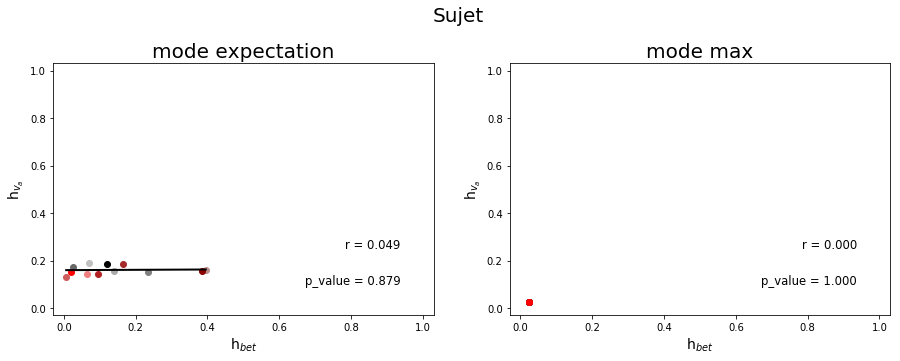

In [13]:
fig, axs = plt.subplots(1, 2, figsize=((fig_width), (fig_width)/(1.6180*2)))
plt.suptitle('Sujet', fontsize=20, y=1.05)

for s, mode in enumerate(['expectation', 'max']):
    for x, color in enumerate(['black','dimgrey','grey','darkgrey','silver','rosybrown','lightcoral','indianred','firebrick','brown','darkred','red']):
        axs[s].scatter(h_bet_sujet[mode][x], h_va_sujet[mode][x],color=color)
        
    #------------------------------------------------------------------------
    axs[s].set_title('mode %s'%mode, fontsize=20)
    axs[s].set_xlabel('h$_{bet}$', fontsize=14)
    axs[s].set_ylabel('h$_{v_a}$', fontsize=14)
    axs[s].axis([-0.03 ,1.03,-0.03,1.03])


    regress(axs[s], h_bet_sujet[mode], h_va_sujet[mode], 'k')

plt.show()

In [14]:
new_h_bet_block, new_h_va_block = {'expectation':[], 'max':[]}, {'expectation':[], 'max':[]}
new_h_bet_pause, new_h_va_pause = {'expectation':[], 'max':[]}, {'expectation':[], 'max':[]}

for mode in ['expectation', 'max']:
    for x in range(len(h_bet_block[mode][0])):
        new_h_bet_block[mode].append([])
        new_h_va_block[mode].append([])
        for a in range(len(h_bet_block[mode])):
            new_h_bet_block[mode][x].append(h_bet_block[mode][a][x])
            new_h_va_block[mode][x].append(h_va_block[mode][a][x])

    for x in range(len(h_bet_pause[mode][0])):
        new_h_bet_pause[mode].append([])
        new_h_va_pause[mode].append([])
        for a in range(len(h_bet_pause[mode])):
            new_h_bet_pause[mode][x].append(h_bet_pause[mode][a][x])
            new_h_va_pause[mode][x].append(h_va_pause[mode][a][x])

/usr/local/lib/python3.5/dist-packages/scipy/stats/_stats_mstats_common.py:107: RuntimeWarning: invalid value encountered in double_scalars
  slope = r_num / ssxm
/usr/local/lib/python3.5/dist-packages/scipy/stats/_stats_mstats_common.py:119: RuntimeWarning: invalid value encountered in double_scalars
  sterrest = np.sqrt((1 - r**2) * ssym / ssxm / df)


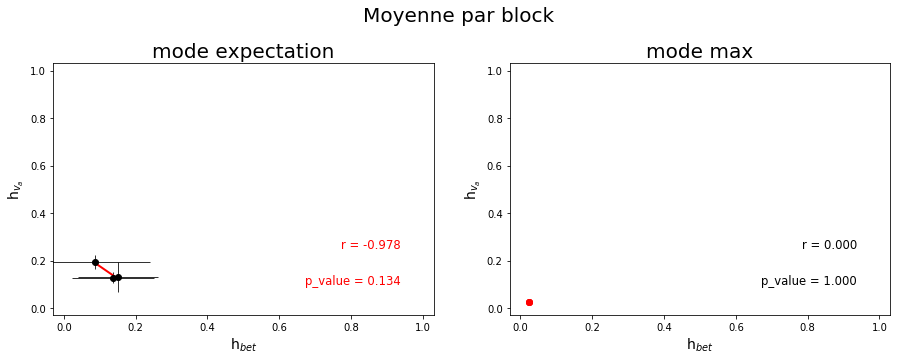

In [15]:
scatter_mean(new_h_bet_block, new_h_va_block, 'Moyenne par block');

/usr/local/lib/python3.5/dist-packages/scipy/stats/_stats_mstats_common.py:107: RuntimeWarning: invalid value encountered in double_scalars
  slope = r_num / ssxm
/usr/local/lib/python3.5/dist-packages/scipy/stats/_stats_mstats_common.py:119: RuntimeWarning: invalid value encountered in double_scalars
  sterrest = np.sqrt((1 - r**2) * ssym / ssxm / df)


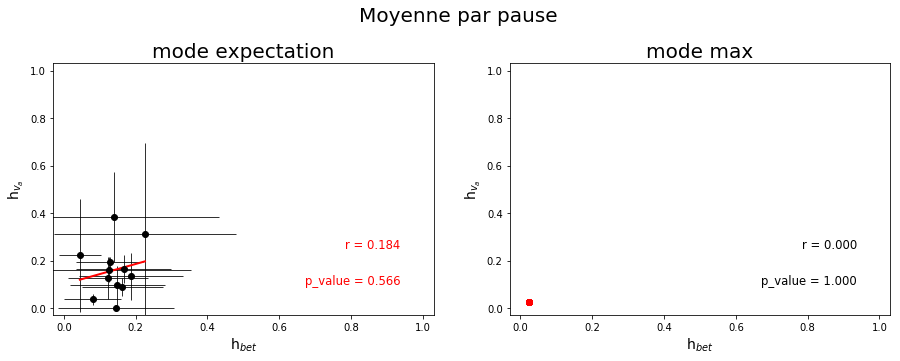

In [16]:
scatter_mean(new_h_bet_pause, new_h_va_pause, 'Moyenne par pause')

/usr/local/lib/python3.5/dist-packages/scipy/stats/_stats_mstats_common.py:107: RuntimeWarning: invalid value encountered in double_scalars
  slope = r_num / ssxm
/usr/local/lib/python3.5/dist-packages/scipy/stats/_stats_mstats_common.py:119: RuntimeWarning: invalid value encountered in double_scalars
  sterrest = np.sqrt((1 - r**2) * ssym / ssxm / df)


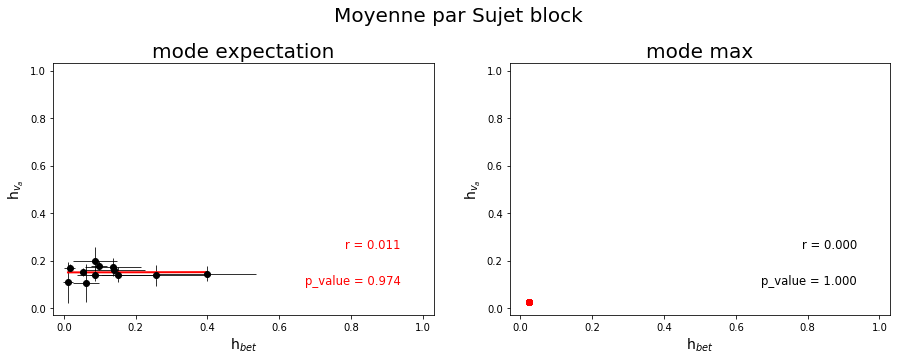

In [17]:
scatter_mean(h_bet_block, h_va_block, 'Moyenne par Sujet block')

/usr/local/lib/python3.5/dist-packages/scipy/stats/_stats_mstats_common.py:107: RuntimeWarning: invalid value encountered in double_scalars
  slope = r_num / ssxm
/usr/local/lib/python3.5/dist-packages/scipy/stats/_stats_mstats_common.py:119: RuntimeWarning: invalid value encountered in double_scalars
  sterrest = np.sqrt((1 - r**2) * ssym / ssxm / df)


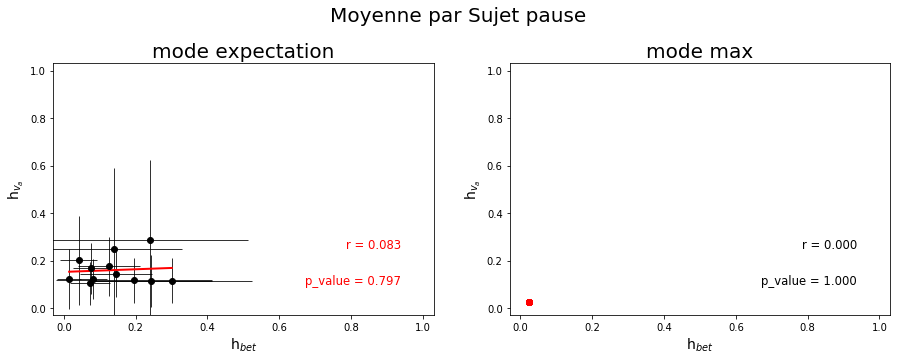

In [18]:
scatter_mean(h_bet_pause, h_va_pause, 'Moyenne par Sujet pause')

/usr/local/lib/python3.5/dist-packages/scipy/stats/_stats_mstats_common.py:107: RuntimeWarning: invalid value encountered in double_scalars
  slope = r_num / ssxm
/usr/local/lib/python3.5/dist-packages/scipy/stats/_stats_mstats_common.py:119: RuntimeWarning: invalid value encountered in double_scalars
  sterrest = np.sqrt((1 - r**2) * ssym / ssxm / df)


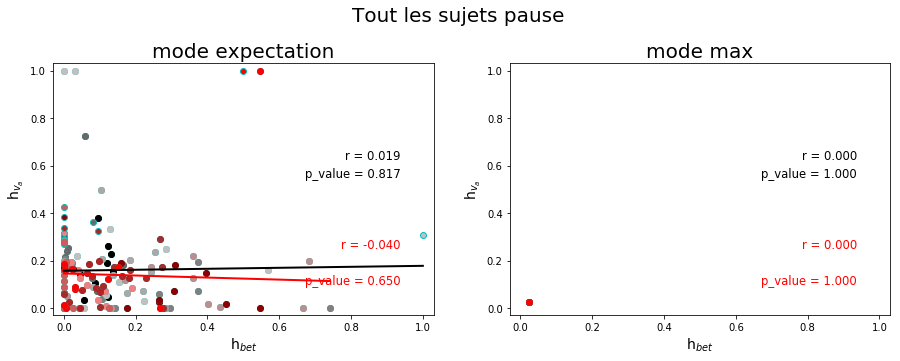

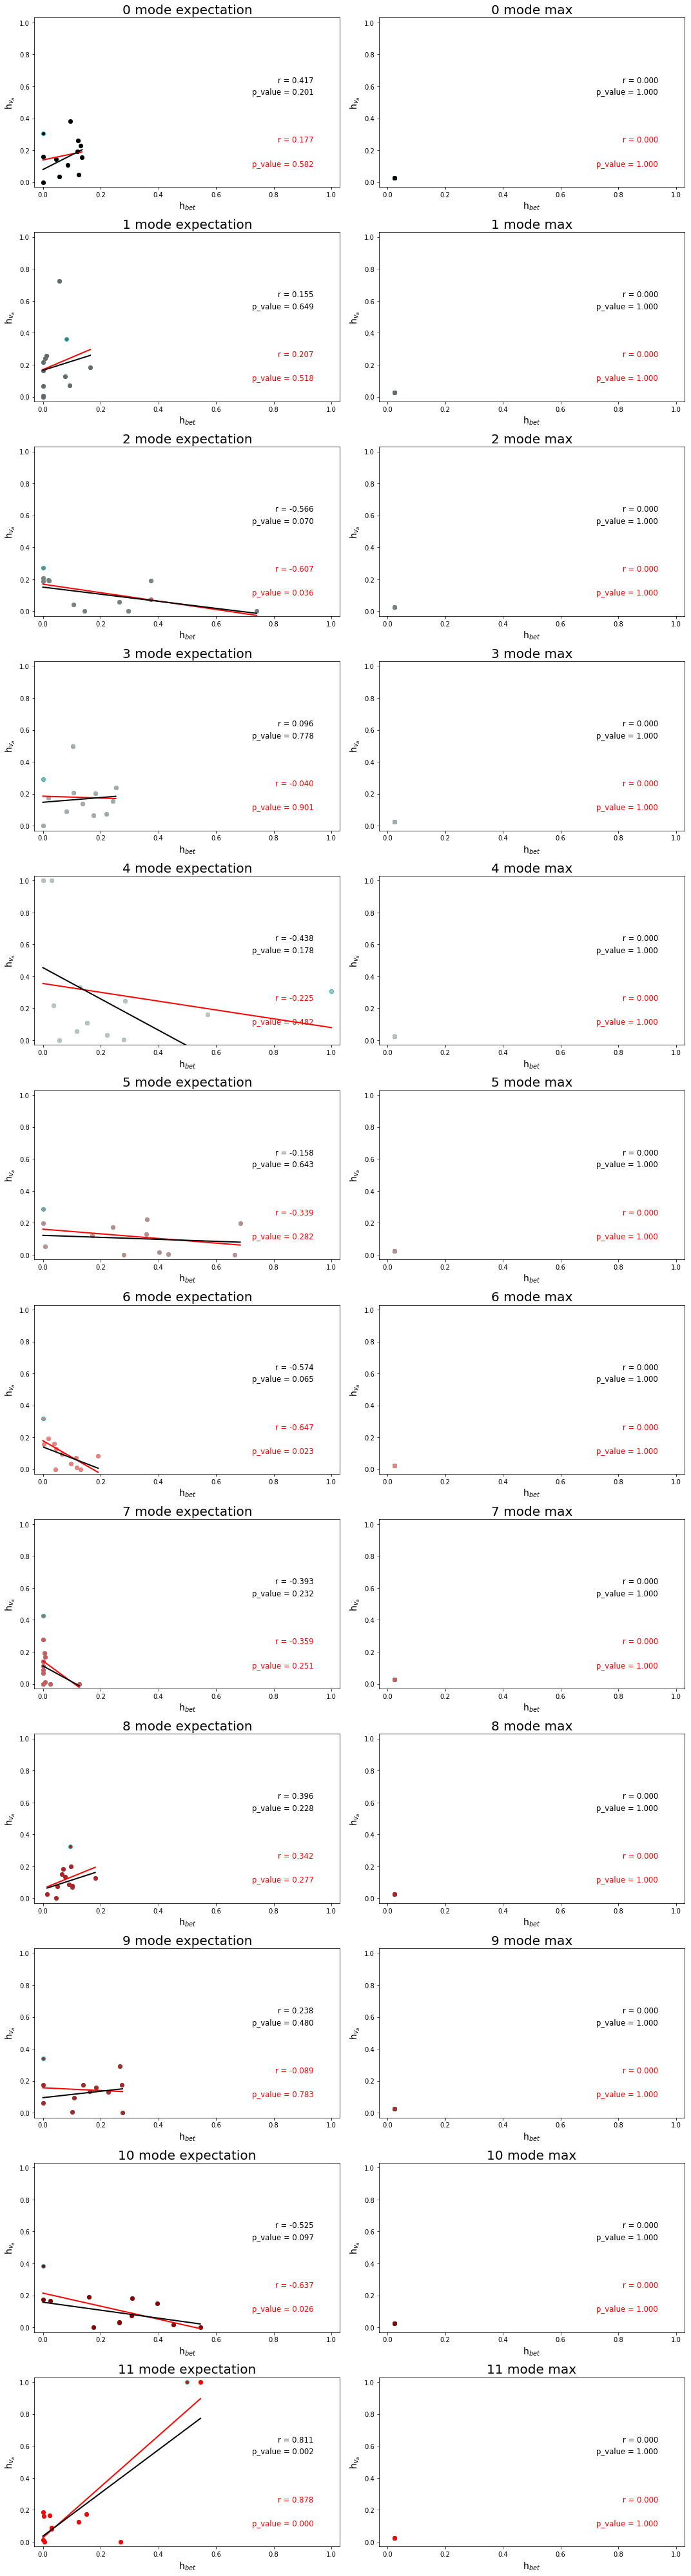

In [19]:
scatter_full(h_bet_pause, h_va_pause, 'Tout les sujets pause')

/usr/local/lib/python3.5/dist-packages/scipy/stats/_stats_mstats_common.py:107: RuntimeWarning: invalid value encountered in double_scalars
  slope = r_num / ssxm
/usr/local/lib/python3.5/dist-packages/scipy/stats/_stats_mstats_common.py:119: RuntimeWarning: invalid value encountered in double_scalars
  sterrest = np.sqrt((1 - r**2) * ssym / ssxm / df)


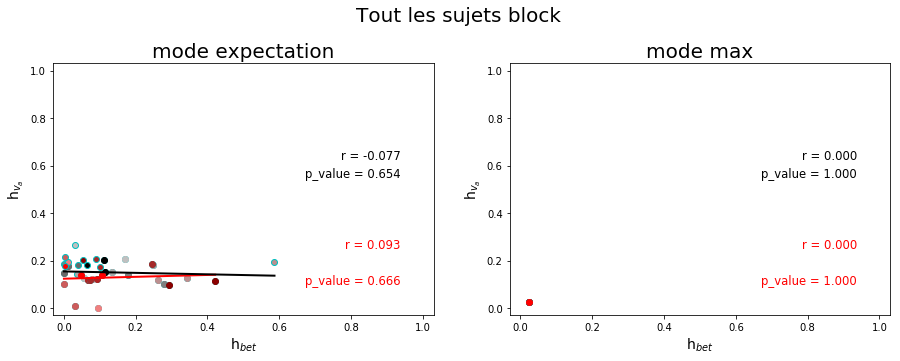

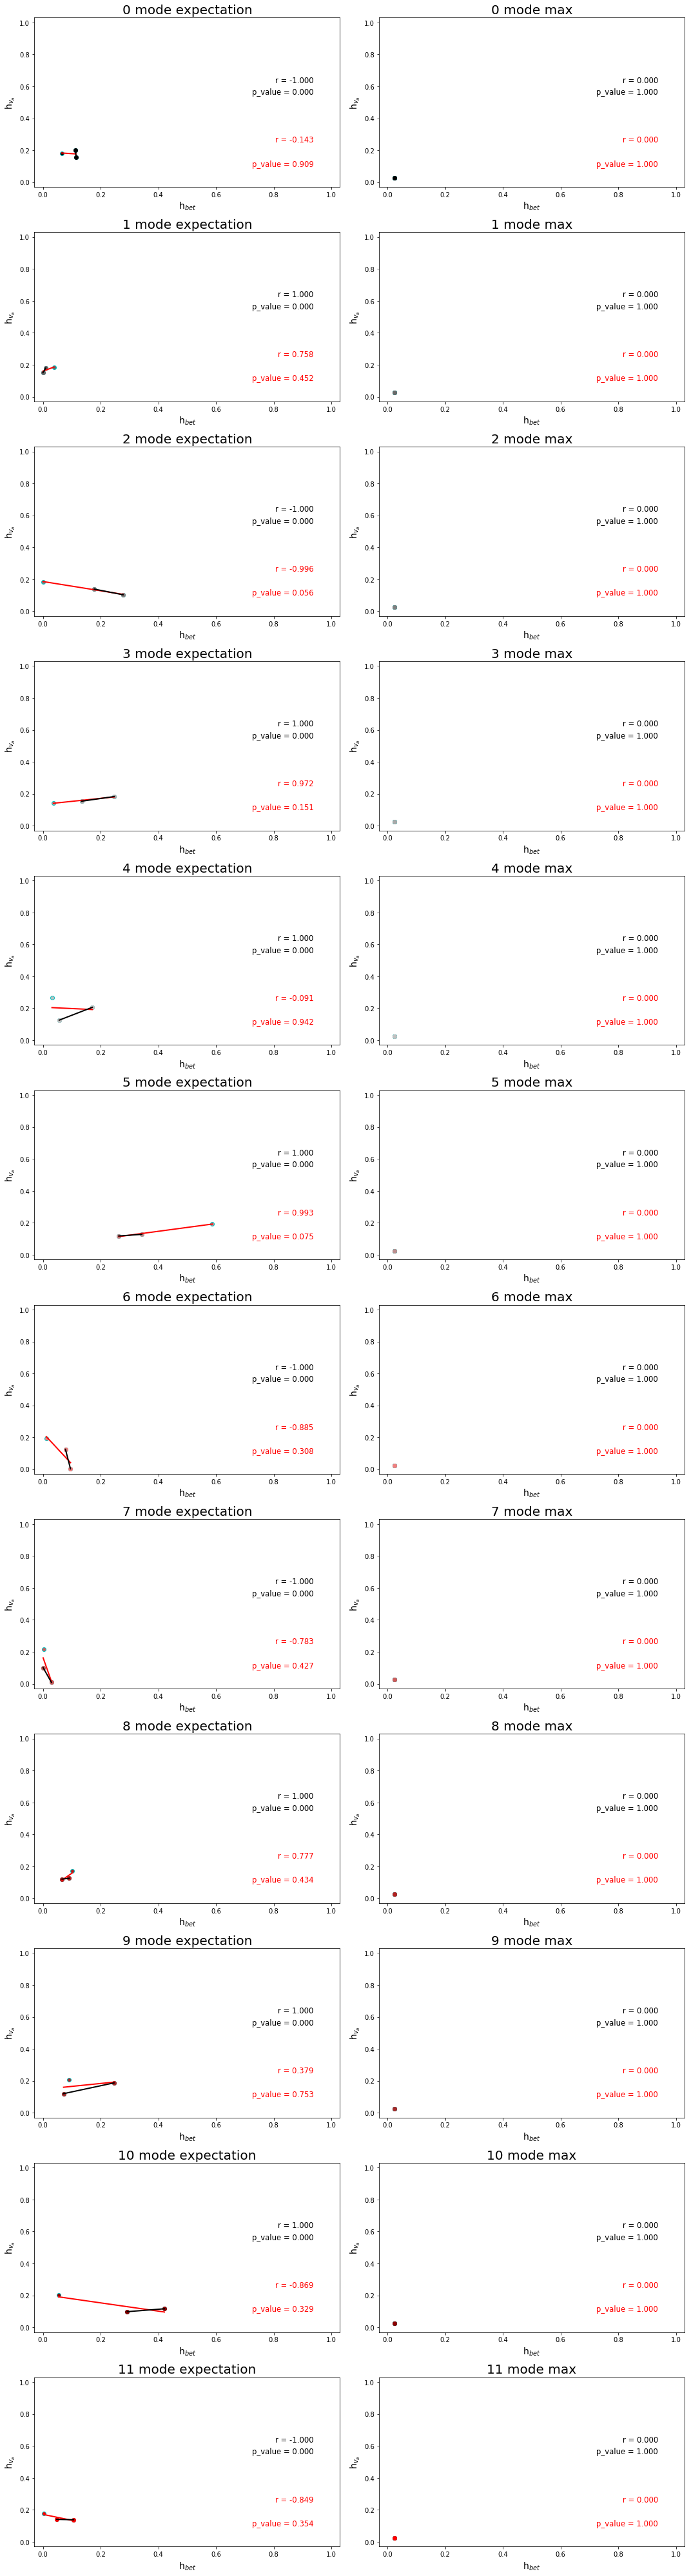

In [20]:
scatter_full(h_bet_block, h_va_block, 'Tout les sujets block')